In [4]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks"


 dataset       task6.ipynb
 dataset.zip  'Копия блокнота "cv toy examples - segmentation.ipynb"'


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/dataset/dataset/images"

1803151818-00001027.jpg  1803242348-00000130.jpg  1803261759-00000291.jpg
1803151818-00001175.jpg  1803242348-00000218.jpg  1803261759-00000449.jpg
1803151818-00001460.jpg  1803242348-00000269.jpg  1803261825-00000001.jpg
1803151818-00001461.jpg  1803242348-00000316.jpg  1803261825-00000048.jpg
1803151818-00001779.jpg  1803242348-00000337.jpg  1803261825-00000089.jpg
1803151818-00019016.jpg  1803242348-00000354.jpg  1803261825-00000210.jpg
1803151818-00019073.jpg  1803242348-00000376.jpg  1803261825-00000218.jpg
1803151818-00019076.jpg  1803242348-00000392.jpg  1803261825-00000248.jpg
1803151818-00019116.jpg  1803242348-00000394.jpg  1803261825-00000328.jpg
1803151818-00019162.jpg  1803242348-00000428.jpg  1803261825-00000414.jpg
1803151818-00019180.jpg  1803242348-00000491.jpg  1803261825-00000425.jpg
1803151818-00019184.jpg  1803250018-00000032.jpg  1803261825-00000517.jpg
1803151818-00019202.jpg  1803250018-00000065.jpg  1803261825-00000526.jpg
1803151818-00019255.jpg  1803250018-00

In [5]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/dataset/dataset/images/1803242348-00000113.jpg", cv2.IMREAD_UNCHANGED)
mask = cv2.imread("/content/drive/MyDrive/Colab Notebooks/dataset/dataset/masks/1803242348-00000113.png", cv2.IMREAD_UNCHANGED)

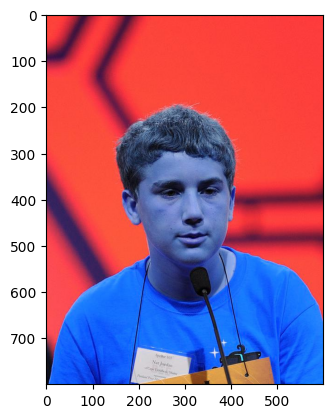

In [ ]:
plt.imshow(img)

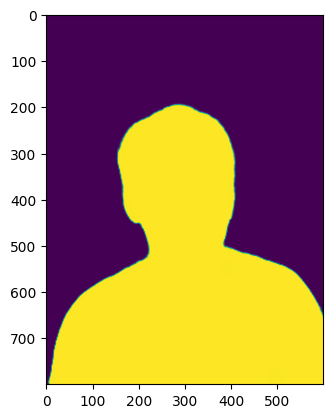

In [ ]:
plt.imshow(mask)

Зафиксируем сиды:

In [8]:
import torch
import random

In [7]:
def random_seeds():
    torch.manual_seed(42)
    random.seed(42)

### Подготовим датасет:

In [9]:
from torch.utils.data import Dataset
import numpy as np
from glob import glob
import torch
from torchvision import io
from torchvision.transforms import functional
from tqdm.auto import tqdm, trange
import pandas as pd
import seaborn as sns

In [10]:
class SelfieDataset(Dataset):
    def __init__(self, images, masks, transform=lambda t: t):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.transform(io.read_image(str(self.images[idx])) / 255)
        mask = self.transform(io.read_image(str(self.masks[idx])) / 255)
        return image, mask

Разбиение на тренировочную и тестовую выборки:

In [11]:
images = sorted(glob("/content/drive/MyDrive/Colab Notebooks/dataset/dataset/images/*"))
masks = sorted(glob("/content/drive/MyDrive/Colab Notebooks/dataset/dataset/masks/*"))

paths = list(zip(images, masks))
random.shuffle(paths)
images, masks = zip(*paths)

train_dataset = SelfieDataset(images[300:], masks[300:])
test_dataset = SelfieDataset(images[:300], masks[:300])

print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 1700
Test dataset length: 300


In [12]:
def show_images(image, mask):
    _, (ax_l, ax_r) = plt.subplots(ncols=2)
    ax_l.imshow(functional.to_pil_image(image))
    ax_l.axis("off")
    ax_r.imshow(functional.to_pil_image(mask))
    ax_r.axis("off")

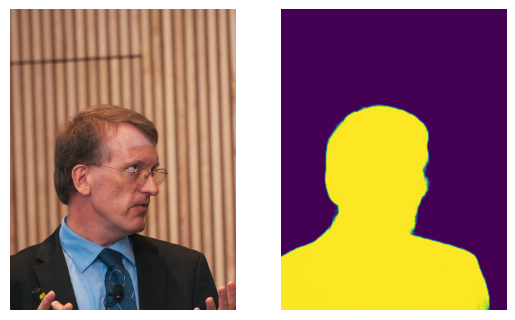

In [10]:
image, mask = train_dataset[0]
show_images(image, mask)

### Добавим Jaccard index:

In [13]:
!pip install torchmetrics  &> /dev/null
import torchmetrics

In [14]:
jaccard = torchmetrics.JaccardIndex(task="binary")

def jaccard_metric(y_pred, y_true):
    return jaccard(y_pred.cpu(), y_true.cpu() > jaccard.threshold)

### UNET

In [15]:
from torch import nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2) 
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x
    
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

In [13]:
criterion = nn.BCEWithLogitsLoss()

def train_epoch(model, optimizer, loader):
    model.train()

    loss_sum = 0
    metric_sum = 0

    for X, y in tqdm(loader, desc="Training batch", disable=False):
        X = X.cuda()
        y = y.cuda()

        pred = model(X)
        loss = criterion(pred, y)
        metric = jaccard_metric(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        metric_sum += metric.item()

    return loss_sum / len(loader), metric_sum / len(loader)


def test(model, loader):
    model.eval()

    loss_sum = 0
    metric_sum = 0
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Test batch", disable=False):
            X = X.cuda()
            y = y.cuda()
            pred = model(X)
            loss_sum += criterion(pred, y).item()
            metric_sum += jaccard_metric(pred, y).item()

    return loss_sum / len(loader), metric_sum / len(loader)


def train(model, optimizer, train_loader, test_loader, epochs=20):

    stats = []
    for epoch_i in trange(epochs, desc="Epoch"):
        loss_train, metric_train = train_epoch(
            model, optimizer, train_loader
        )
        loss_test, metric_test = test(model, test_loader)
        stats += [
            (epoch_i, "Loss", "Train", loss_train),
            (epoch_i, "Jaccard", "Train", metric_train),
            (epoch_i, "Loss", "Test", loss_test),
            (epoch_i, "Jaccard", "Test", metric_test),
        ]

    return pd.DataFrame(stats, columns=["Epoch", "Statistic", "Dataset", "Result"])


In [16]:
def show_result(res, plot_title = ""):
    fig, (ax_1, ax_2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))

    sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
    ax_1.set_title("Loss")

    sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))
    ax_2.set_title("Jaccard")

    fig.suptitle(plot_title)
    fig.tight_layout()

## Переобучение на одном батче из 4 картинок:

In [ ]:
random_seeds()

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, range(4)),
    batch_size=4,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dataset, range(4)),
    batch_size=4,
)

In [ ]:
net = UNET(3, 16, 1).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

res = train(net, optimizer, train_loader, test_loader, epochs=60)

<ipython-input-31-769c8ef4c587>:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
<ipython-input-31-769c8ef4c587>:7: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))


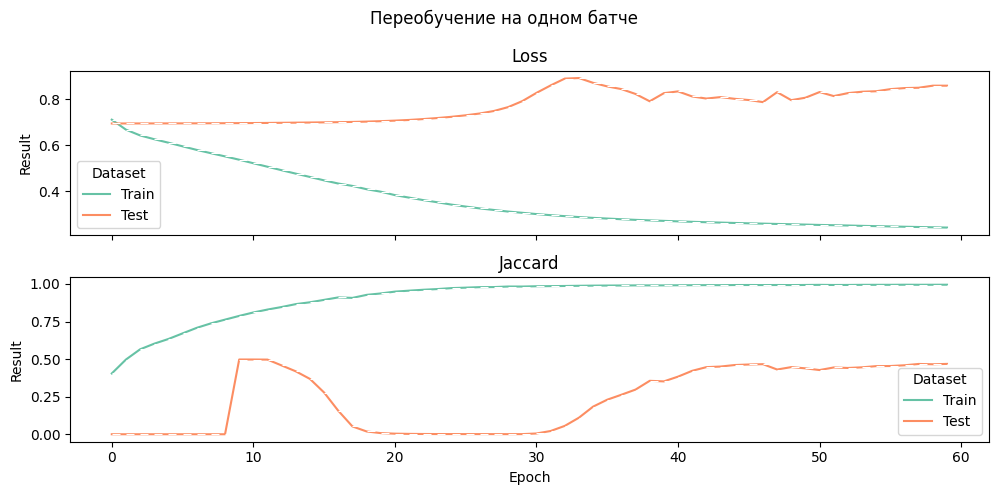

In [ ]:
show_result(res, "Переобучение на одном батче")

Видно, что на обучающей выборке функция потерь и индекс Жаккара имеют, хорошие показатели. Однако, на тестовой выборке индекс Жаккара не превышает 0.5, а потери стремятся к единице.

Посмотрим на результат переобучения.

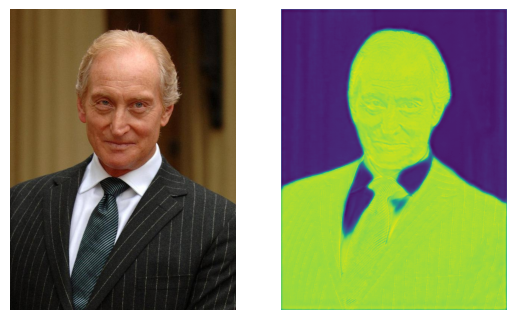

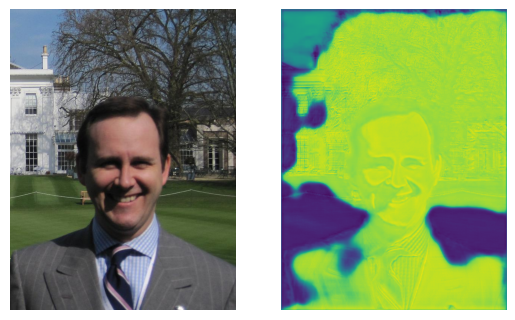

In [ ]:
net.eval()


train_img, mask = train_dataset[1]
train_mask = net(train_img.cuda().unsqueeze(0))[0].cpu()
show_images(train_img, nn.functional.sigmoid(train_mask))

test_img, mask = test_dataset[0]
test_mask = net(test_img.cuda().unsqueeze(0))[0].cpu() 
show_images(test_img, nn.functional.sigmoid(test_mask))

Видим хорошие результаты на тренировочной выборке и плохие на тестовой.

## Обучение на всем Train:

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=6)

In [ ]:
net = UNET(3, 16, 1).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

res = train(net, optimizer, train_loader, test_loader, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training batch:   0%|          | 0/213 [00:00<?, ?it/s]

Test batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/213 [00:00<?, ?it/s]

Test batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/213 [00:00<?, ?it/s]

Test batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/213 [00:00<?, ?it/s]

Test batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/213 [00:00<?, ?it/s]

Test batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/213 [00:00<?, ?it/s]

Test batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/213 [00:00<?, ?it/s]

Test batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/213 [00:00<?, ?it/s]

Test batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/213 [00:00<?, ?it/s]

Test batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/213 [00:00<?, ?it/s]

Test batch:   0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-31-769c8ef4c587>:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
<ipython-input-31-769c8ef4c587>:7: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))


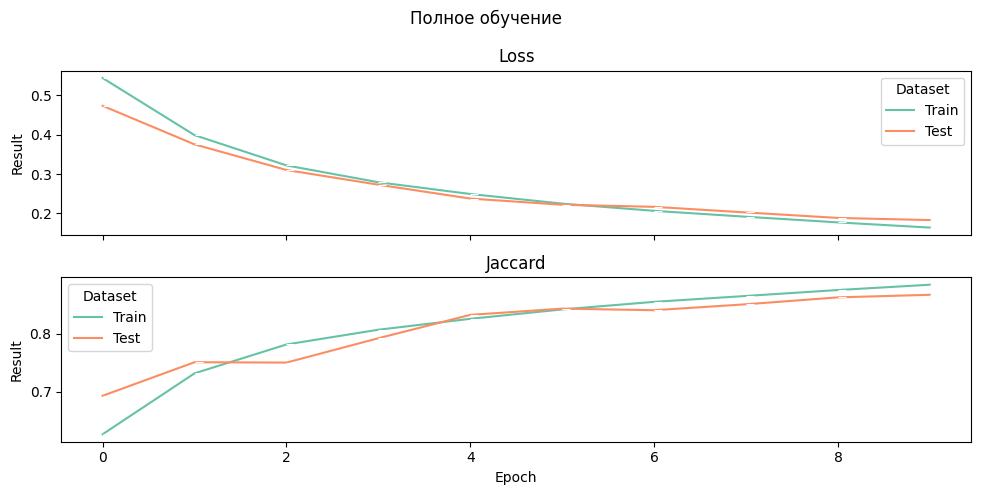

In [ ]:
show_result(res, "Полное обучение")

Видим, что качество модели сильно улучшилось. Jaccard index тестовой выборки близок, к 0.9, что очень хорошо. Графики для тестовой и обучающей выборки имеют одинаковый характер возрастания/убывания.

### Посмотрим на 3 худших результата:

0it [00:00, ?it/s]

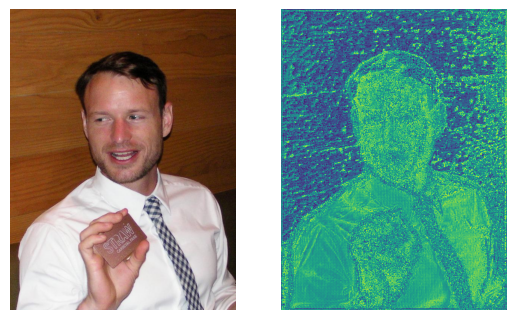

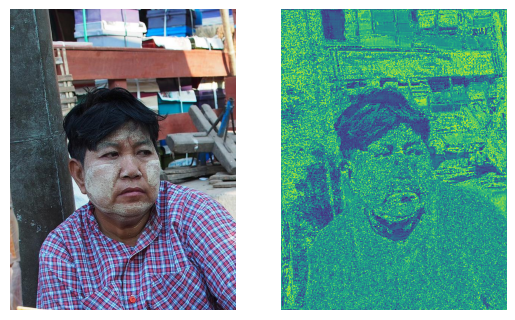

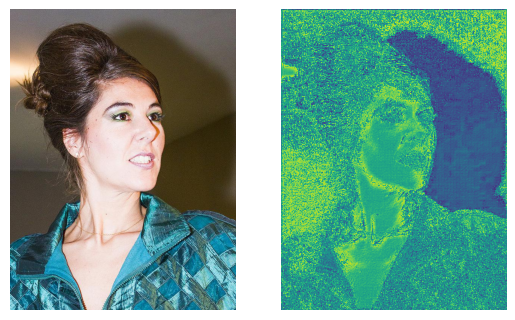

In [ ]:
predictions = []
with torch.no_grad():
  for i, data in tqdm(enumerate(test_loader, 0)):
            x = data[0]
            y = data[1]
            pred = net(x.cuda())
            metric = jaccard_metric(pred, y).item()
            predictions.append((metric, i))

worst_res = sorted(predictions)[:3]
for _, idx in worst_res:
        image, mask = test_dataset[idx]
        pred = net(image.cuda().unsqueeze(0))
        show_images(image, pred[0].cpu())

In [ ]:
torch.cuda.empty_cache()

Объекты получаются зашумленными и смешанными с фоном, однако, образы все равно распознаются достаточно неплохо. Скорее всего это связано с освещеним и сильным контрастом на изображениях.

## Аугментация

In [23]:
from torchvision import transforms

In [24]:
class UnetWrapper(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, image):
        flipped_image = transforms.functional.hflip(image)
        concatenated_image = torch.cat([image, flipped_image])
        prediction = self.net(concatenated_image)
        result, augmented_result = prediction.chunk(2)
        flipped_augmented_result = transforms.functional.hflip(augmented_result)
        return torch.mean(torch.stack([result, flipped_augmented_result]), dim=0)

In [25]:
net = UNET(3, 16, 1).cuda()
aug_net = UnetWrapper(net).cuda()

optimizer = torch.optim.Adam(aug_net.parameters())
res = train(aug_net, optimizer, train_loader, test_loader, 10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training batch:   0%|          | 0/284 [00:00<?, ?it/s]

Test batch:   0%|          | 0/50 [00:00<?, ?it/s]

Training batch:   0%|          | 0/284 [00:00<?, ?it/s]

Test batch:   0%|          | 0/50 [00:00<?, ?it/s]

Training batch:   0%|          | 0/284 [00:00<?, ?it/s]

Test batch:   0%|          | 0/50 [00:00<?, ?it/s]

Training batch:   0%|          | 0/284 [00:00<?, ?it/s]

Test batch:   0%|          | 0/50 [00:00<?, ?it/s]

Training batch:   0%|          | 0/284 [00:00<?, ?it/s]

Test batch:   0%|          | 0/50 [00:00<?, ?it/s]

Training batch:   0%|          | 0/284 [00:00<?, ?it/s]

Test batch:   0%|          | 0/50 [00:00<?, ?it/s]

Training batch:   0%|          | 0/284 [00:00<?, ?it/s]

Test batch:   0%|          | 0/50 [00:00<?, ?it/s]

Training batch:   0%|          | 0/284 [00:00<?, ?it/s]

Test batch:   0%|          | 0/50 [00:00<?, ?it/s]

Training batch:   0%|          | 0/284 [00:00<?, ?it/s]

Test batch:   0%|          | 0/50 [00:00<?, ?it/s]

Training batch:   0%|          | 0/284 [00:00<?, ?it/s]

Test batch:   0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-15-769c8ef4c587>:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
<ipython-input-15-769c8ef4c587>:7: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))


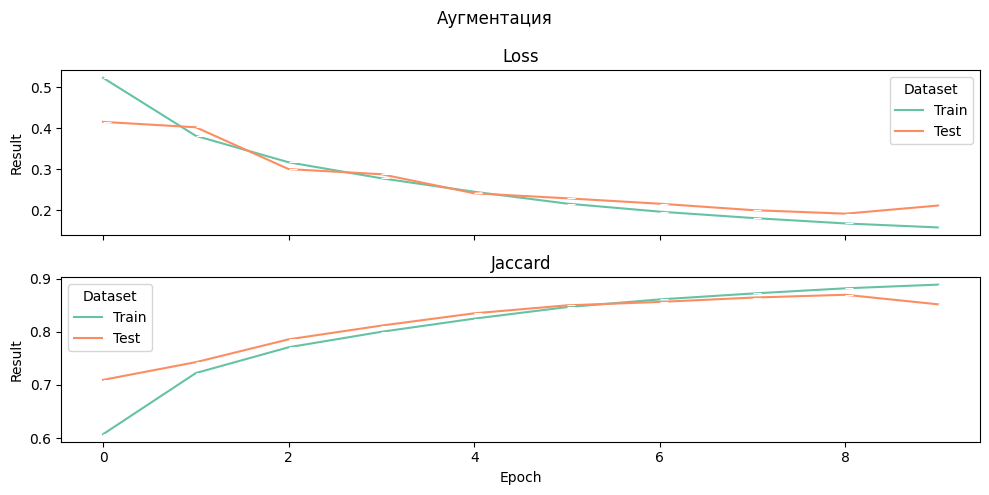

In [26]:
show_result(res, "Аугментация")

Аугментация улучшила качество модели на обучающей выборке, в то время как на тестовой существенных улучшений нет.

## Изменение архитектуры модели

В качестве обновленной архитектуры будем использовать Unet2, которая использует DoubleConv блоки вместо обычных сверточных блоков, используемых в UNet. В целом Unet2 должна показывать более высокое качество сегментации.

In [24]:
from torch import nn
import torch
import torchvision.transforms.functional as TF


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernal_size, strides, padding):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernal_size, strides, padding, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernal_size, strides, padding, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class NUNet(nn.Module):
    def __init__(self, in_channels, num_segmentations=1, features=[8, 16, 32, 64]):
        super(NUNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.bottleneck = DoubleConv(
            in_channels=features[-1],
            out_channels=features[-1]*2,
            kernal_size=3,
            strides=1,
            padding=1
        )
        self.output = nn.Conv2d(
            in_channels=features[0],
            out_channels=num_segmentations,
            kernel_size=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        in_channels_iter = in_channels
        for feature in features:
            self.downs.append(DoubleConv(
                    in_channels=in_channels_iter,
                    out_channels=feature,
                    kernal_size=3,
                    strides=1,
                    padding=1
                ))
            in_channels_iter = feature

        for feature in reversed(features):
            up = nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels=feature*2,
                    out_channels=feature,
                    kernel_size=2,
                    stride=2,
                    padding=0
                ),
                DoubleConv(
                    in_channels=feature*2,
                    out_channels=feature,
                    kernal_size=3,
                    padding=1,
                    strides=1
                )
            )

            self.ups.append(up)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(len(self.ups)):
            x = self.ups[i][0](x)

            skip_connection = skip_connections[i]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_x = torch.cat((skip_connection, x), dim=1)

            x = self.ups[i][1](concat_x)

        return self.output(x)

In [25]:
net = NUNet(3)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

res = train(net, optimizer, train_loader, test_loader, epochs=8)

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Training batch:   0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training batch:   0%|          | 0/425 [00:00<?, ?it/s]

Test batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training batch:   0%|          | 0/425 [00:00<?, ?it/s]

Test batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training batch:   0%|          | 0/425 [00:00<?, ?it/s]

Test batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training batch:   0%|          | 0/425 [00:00<?, ?it/s]

Test batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training batch:   0%|          | 0/425 [00:00<?, ?it/s]

Test batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training batch:   0%|          | 0/425 [00:00<?, ?it/s]

Test batch:   0%|          | 0/75 [00:00<?, ?it/s]

Training batch:   0%|          | 0/425 [00:00<?, ?it/s]

Test batch:   0%|          | 0/75 [00:00<?, ?it/s]

In [17]:
criterion = nn.BCEWithLogitsLoss()

def train_epoch(model, optimizer, loader):
    model.train()

    loss_sum = 0
    metric_sum = 0

    for X, y in tqdm(loader, desc="Training batch", disable=False):
        X = X
        y = y

        pred = model(X)
        loss = criterion(pred, y)
        metric = jaccard_metric(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        metric_sum += metric.item()

    return loss_sum / len(loader), metric_sum / len(loader)


def test(model, loader):
    model.eval()

    loss_sum = 0
    metric_sum = 0
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Test batch", disable=False):
            X = X
            y = y
            pred = model(X)
            loss_sum += criterion(pred, y).item()
            metric_sum += jaccard_metric(pred, y).item()

    return loss_sum / len(loader), metric_sum / len(loader)


def train(model, optimizer, train_loader, test_loader, epochs=20):

    stats = []
    for epoch_i in trange(epochs, desc="Epoch"):
        loss_train, metric_train = train_epoch(
            model, optimizer, train_loader
        )
        loss_test, metric_test = test(model, test_loader)
        stats += [
            (epoch_i, "Loss", "Train", loss_train),
            (epoch_i, "Jaccard", "Train", metric_train),
            (epoch_i, "Loss", "Test", loss_test),
            (epoch_i, "Jaccard", "Test", metric_test),
        ]

    return pd.DataFrame(stats, columns=["Epoch", "Statistic", "Dataset", "Result"])


<ipython-input-14-769c8ef4c587>:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Loss"], x="Epoch", y="Result", hue="Dataset",ax=ax_1, marker = True, palette=sns.color_palette("Set2"))
<ipython-input-14-769c8ef4c587>:7: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(res[res["Statistic"] == "Jaccard"], x="Epoch", y="Result", hue="Dataset", ax=ax_2, marker = True, palette=sns.color_palette("Set2"))


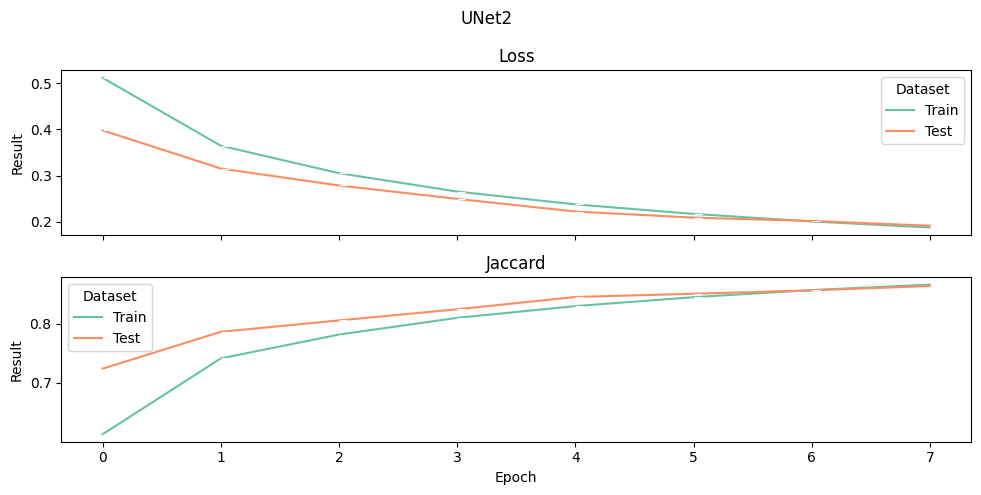

In [26]:
show_result(res, "UNet2")

Пока что UNet2 показала лучшее качество.

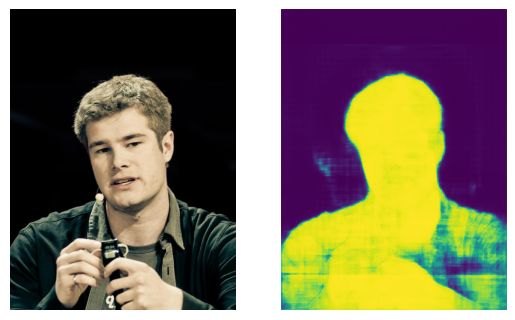

In [29]:
test_img, mask = test_dataset[15]
test_mask = net(test_img.unsqueeze(0))[0] 
show_images(test_img, nn.functional.sigmoid(test_mask))

## Кросс-валидация